# *Libraries*

In [102]:
import os
import tensorflow as tf
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# *Load data*

In [103]:
def load() :
    train_dir = "/Users/mika/Applied-Machine-Learning/Project/dataset/CNN_Input/train"
    test_dir = "/Users/mika/Applied-Machine-Learning/Project/dataset/CNN_Input/test" 

    # Load train data
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'
    )

    # Load test data
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'  # Categorical labels for multi-class classification
    )
    
    return test_data, train_data

# *Plot 8 images*

In [104]:
def plot_img(train_data) :
    class_names = train_data.class_names  
    plt.figure(figsize=(8, 5)) 
    for images, labels in train_data.take(1):  # Take one batch from the dataset
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1) 
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i].numpy())])
            plt.axis("off")
        plt.subplots_adjust(hspace=0, wspace=0)
        plt.show()

# *Data preparation*

In [105]:
def normalize_img(train_data, test_data):
   
    def normalize(image, label):
        image = image / 255.0  
        return image, label  
        
    # Normalization to both train and test datasets
    train_data_norm = train_data.map(normalize)
    test_data_norm = test_data.map(normalize)

    return test_data_norm, train_data_norm

# *Build and Compile CNN*

In [106]:
# Build the CNN model for multi-class classification
def build_cnn_model():
    model = models.Sequential([
        layers.InputLayer(shape=(150, 150, 3)),  # Input shape (150x150x3)
        
        # Convolutional layers with max pooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten the output and pass through dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 output units, one for each class (good, bad, contaminated, etc.)
    ])
    
    # Compile the model with sparse categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# *Train model*

In [107]:
# Stop training early if no improvement in validation loss for 5 epochs

def train_model(model, train_data_norm, test_data_norm):

    callbacks = [  
        # Stop training early if no improvement in validation loss for 5 epochs
         EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True
        ),
        # Reduce learning rate if validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=3 
        )
    ]
    
    history = model.fit(
        train_data_norm,
        epochs=70,
        validation_data=test_data_norm,
        callbacks=callbacks
    )
    return history

# *Plotting Training and Validation Figures*

In [108]:
def plot_metrics(history): # Insert parameter name

    # Plot traning and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot traning and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# *Main*

Found 83 files belonging to 4 classes.
Found 83 files belonging to 4 classes.


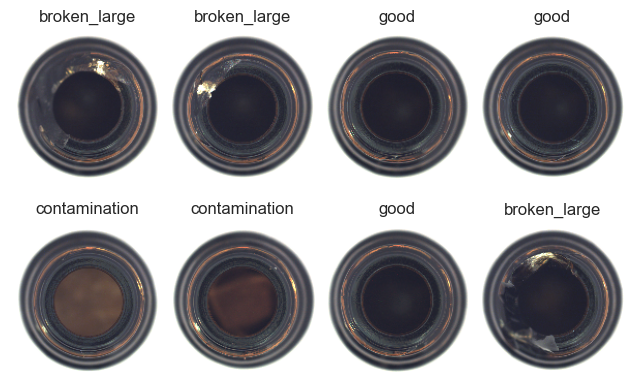

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 19, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,428 (622.77 KB)

 Trainable params: 159,428 (622.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.2225 - loss: 1.4342 - val_accuracy: 0.3253 - val_loss: 1.3847 - learning_rate: 0.0010
Epoch 2/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.3224 - loss: 1.3877 - val_accuracy: 0.2651 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 3/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.2702 - loss: 1.3872 - val_accuracy: 0.2530 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 4/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.2541 - loss: 1.3813 - val_accuracy: 0.4217 - val_loss: 1.3821 - learning_rate: 0.0010
Epoch 5/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.3000 - loss: 1.3843 - val_accuracy: 0.2771 - val_loss: 1.3785 - learning_rate: 0.0010
Epoch 6/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.3137 - loss: 1.3763 - val_accuracy: 0.4699 - val_loss: 1.3737 - learning_rate: 0.0010
Epoch 7/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3487 - loss: 1.3734 - val_accuracy: 

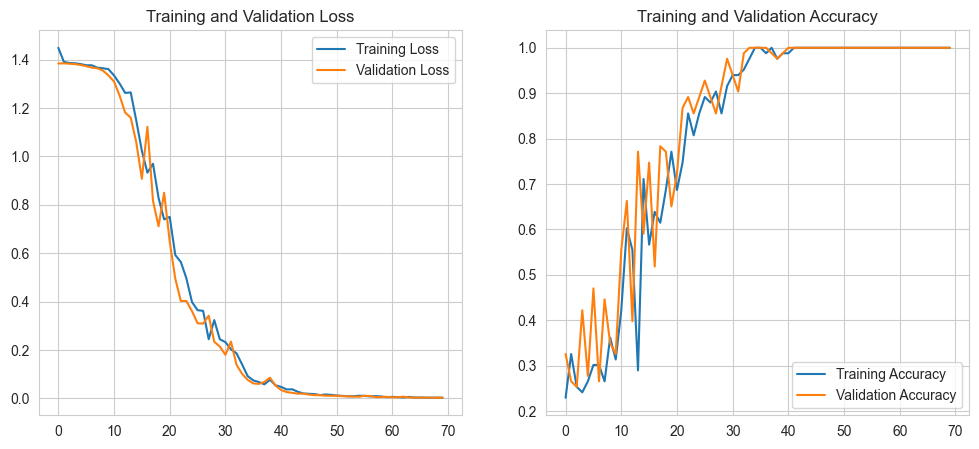

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0022
Test Loss: 0.0022177149076014757
Test Accuracy: 100.00%


In [109]:
test_data, train_data = load()
plot_img(train_data)

test_data_norm, train_data_norm = normalize_img(train_data, test_data)
model = build_cnn_model()
model.summary()
history = train_model(model, train_data_norm, test_data_norm)
plot_metrics(history)

test_loss, test_accuracy = model.evaluate(test_data_norm)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")